In [2]:
!pip install statsmodels

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [3]:
def stationarity_check(ts):
    result = adfuller(ts)
    print(f"ADF Statistic : {result[0]}")
    print(f"p-value:{result[1]}")
    print(f"Critical values : {result[4]}")

def plot_acf_pacf(ts):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
    plot_acf(ts,ax=ax1,lags=20)
    plot_pacf(ts,ax=ax2,lags=20)
    plt.show()

In [4]:
stock_symbol = "AAPL"
start_date = "2015-01-01"
end_date = "2023-01-01"
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)['Close']

/tmp/ipykernel_8932/1853554278.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed


In [5]:
stock_data

Ticker,AAPL
Date,
2015-01-02,24.237553
2015-01-05,23.554741
2015-01-06,23.556957
2015-01-07,23.887281
2015-01-08,24.805080
...,...
2022-12-23,129.900284
2022-12-27,128.097504
2022-12-28,124.166794


In [6]:
log_returns = stock_data.pct_change().dropna()
log_returns = log_returns.apply(lambda x:np.log(1+x))

In [7]:
# Check stationarity
stationarity_check(log_returns)

# Differencing to make the series stationary
log_returns_diff = log_returns.diff().dropna()

# Check stationarity after differencing
stationarity_check(log_returns_diff)

ADF Statistic : -13.847569693844001
p-value:7.102739107286922e-26
Critical values : {'1%': np.float64(-3.4336173133865064), '5%': np.float64(-2.86298332472282), '10%': np.float64(-2.5675383641200633)}
ADF Statistic : -14.05407287320829
p-value:3.1399517237660585e-26
Critical values : {'1%': np.float64(-3.433648628001351), '5%': np.float64(-2.8629971502062155), '10%': np.float64(-2.5675457254979093)}


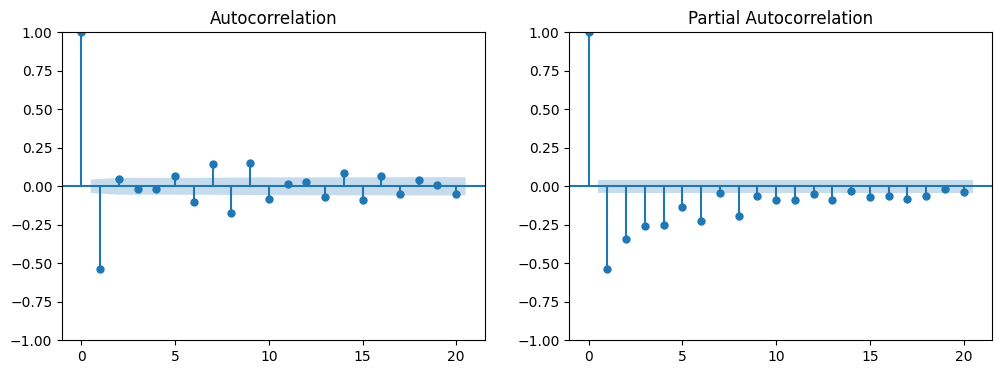

In [8]:
plot_acf_pacf(log_returns_diff)

In [ ]:
best_aic = float('inf')
best_bic = float('inf')
best_order = None

for p in range(4):
    for d in range(2):
        for q in range(4):
            arima_model = ARIMA(log_returns,order=(p,d,q))
            arima_results = arima_model.fit()

            current_aic = arima_results.aic
            current_bic = arima_results.bic

            if current_aic<best_aic and current_bic<best_bic:
                best_aic = current_aic
                best_bic = current_bic
                best_order = (p,d,q)
print(f"Best AIC : {best_aic} , Best BIC : {best_bic} , Best order : {best_order}")

/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored whe

In [10]:
import pmdarima as pm
#arima_model = pm.auto_arima(log_returns, seasonal=False, trace=True)

arima_model = ARIMA(log_returns,order=(2,1,4))
arima_results = arima_model.fit()
#arima_results =  arima_model.summary()

/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/a-anuj/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

In [11]:
residuals = arima_results.resid
stationarity_check(residuals)

ADF Statistic : -44.77719775733105
p-value:0.0
Critical values : {'1%': np.float64(-3.433604305449515), '5%': np.float64(-2.8629775816425003), '10%': np.float64(-2.5675353062242845)}


In [12]:
lb_test_stat = acorr_ljungbox(residuals, lags=40)
print(f'{lb_test_stat}')

      lb_stat  lb_pvalue
1    0.006667   0.934922
2    2.576526   0.275749
3    3.982433   0.263367
4    4.782989   0.310297
5    4.826922   0.437366
6    6.538124   0.365678
7    7.547042   0.374222
8    8.546931   0.381944
9   13.519324   0.140480
10  13.519331   0.196066
11  13.521163   0.260630
12  13.642583   0.324112
13  13.642986   0.399458
14  13.805720   0.464283
15  13.884830   0.534281
16  13.960765   0.601637
17  17.172952   0.442709
18  18.558701   0.419457
19  22.574151   0.256620
20  24.073827   0.239182
21  24.460332   0.271293
22  29.350683   0.135118
23  29.352238   0.168914
24  29.363868   0.206737
25  30.001378   0.224237
26  30.366159   0.252720
27  30.412850   0.295926
28  32.787327   0.243664
29  33.081598   0.274460
30  33.920333   0.284029
31  36.605174   0.224653
32  36.807090   0.256024
33  36.809768   0.296861
34  36.837380   0.338938
35  37.156301   0.369942
36  37.435564   0.403074
37  38.521990   0.400561
38  38.536827   0.445212
39  38.611106   0.487452


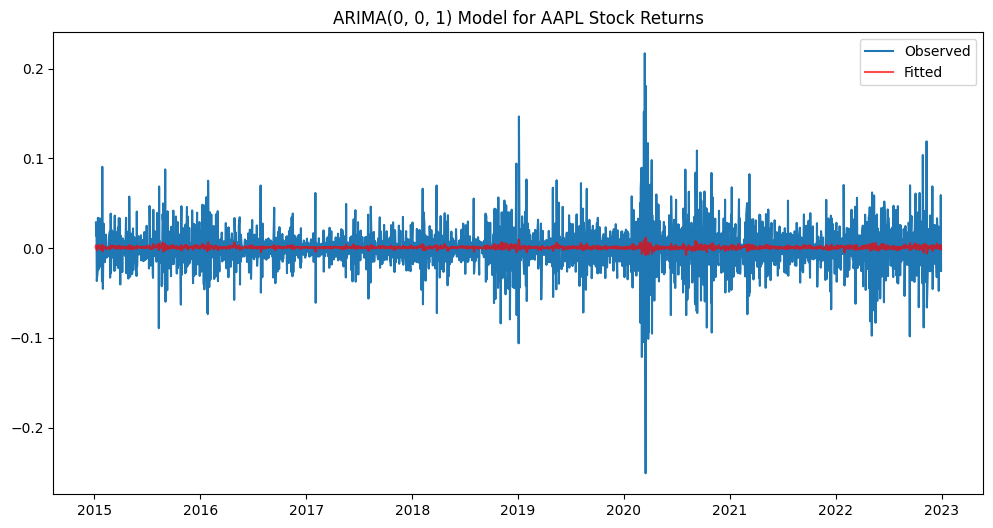

In [15]:
# Plotting the predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(log_returns_diff, label='Observed')
plt.plot(arima_results.fittedvalues, color='red', label='Fitted', alpha=0.7)
plt.legend()
plt.title(f'ARIMA{best_order} Model for {stock_symbol} Stock Returns')
plt.show()

In [24]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.9/688.9 kB 4.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 5.0 MB/s  0:00:005.3 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pmdarima]━━ 1/2 [pmdarima]
Note: you may need to restart the kernel to use updated packages.
